In [18]:
%pylab inline --no-import-all

from ctypes import c_float
import sys

# import numpy as np
from astropy.io import fits


from ROOT import gSystem, TFile, TCanvas, TGraphAsymmErrors, TH1D, TH2D, TGraphAsymmErrors, TProfile
import uproot
import matplotlib.pyplot as plt

from root_numpy import hist2array

# from ROOT import VARootIO, VAEffectiveAreaManager, VAEASimpleParameterData


Populating the interactive namespace from numpy and matplotlib


VEGAS libraries (not used for eventDisplay obviously!)

In [19]:
# if gSystem.Load("libVEGASCommon"):
#     print "Problem loading VEGAS Common libraries - please check this before proceeding"
# if gSystem.Load("libVEGASStage6"):
#     print "Problem loading VEGAS Stage 6 libraries - please check this before proceeding"

Load eventdisplay libraries:

In [20]:
if gSystem.Load("$EVNDISPSYS/lib/libVAnaSum.so"):
    print("Problem loading EventDisplay libraries - please check this before proceeding")
    
from ROOT import VInstrumentResponseFunctionData

Problem loading EventDisplay libraries - please check this before proceeding


# Compatability
Works with VEGAS v2.5.7 or later.

# Data format
the data format is defined at : https://gamma-astro-data-formats.readthedocs.io/en/latest/

# Task List

## Top priorities
* Time Cuts from ROOT file
* Average Azimuth assumes southerly source ....
* Convert to format so can read through a stage 6 runlist file
* Check validity of 30 min runs for EA (compare decent Crab runlist in 30 vs 10 min runs @ different zenith angles).
* Adding ED capability.

## Validation
* Check high stats crab spectra
* Check other spectra
* Check significances/sky maps
* Upper limits

## Documentation
* Save a number of notebooks that show how to do conversion and analysis

## Wish list
* All offset - this will require reworking events list for saving noises etc.
* Event Types - how do spectra compare when produced as "all events" vs. breaking up into 2, 3 and 4 tel events.
* Get window size for noise from root/ea file - at the moment assume it is 7

In [4]:
edFileIO = TFile.Open("/home/thassan/VERITAS/DL3/eventDisplay/54809.anasum.root")

Warning in <TClass::Init>: no dictionary for class VAnaSumRunParameterListOfExclusionRegions is available


In [5]:
from ROOT import VTimeMask, VEvndispRunParameter, VSkyCoordinatesUtilities
from astropy.time import Time
# runParameters = edFileIO.Get("run_54809/stereo/VAnaSumRunParameter")
runParametersV2 = edFileIO.Get("run_54809/stereo/runparameterV2")
type(runParametersV2)

ROOT.VEvndispRunParameter

Warning in <TStreamerInfo::BuildOld>: Cannot convert VEvndispRunParameter::fDoublePass from type: bool to type: vector<bool>, skip element
Warning in <TStreamerInfo::BuildOld>: Cannot convert VEvndispRunParameter::fDoublePassErrorWeighting2005 from type: bool to type: vector<bool>, skip element


This should be the content of "def __fillEVENTS_not_safe__(edFileIO):"

In [6]:
import numpy as np
import logging
from root_numpy import tree2array
from astropy.time import Time

# EventDisplay imports
from ROOT import VEvndispRunParameter, VSkyCoordinatesUtilities, VAnaSumRunParameter, VTimeMask

logger = logging.getLogger(__name__)


evt_dict = {}

# FIXME: This should be taken from a common script (by VEGAS also)
reference_mjd = 53402.0

# Load header ,array info and selected event tree ( vegas > v2.5.7)
runSummary = tree2array(edFileIO.Get("total_1/stereo/tRunSummary"))
runNumber = runSummary['runOn'][0]
telConfig = tree2array(edFileIO.Get("run_{}/stereo/telconfig".format(runNumber)))
runParametersV2 = edFileIO.Get("run_{}/stereo/runparameterV2".format(runNumber))
vAnaSumRunParameter = edFileIO.Get("run_{}/stereo/VAnaSumRunParameter".format(runNumber))
selectedEventsTree = tree2array(edFileIO.Get("run_{}/stereo/TreeWithEventsForCtools".format(runNumber)))
anasumEffectiveArea = edFileIO.Get("run_{}/stereo/EffectiveAreas/gMeanEffectiveArea".format(runNumber))

# qStatsData = edFileIO.loadTheQStatsData()
# pixelData = edFileIO.loadThePixelStatusData()
# arrayInfo          = edFileIO.loadTheArrayInfo(0)
# cuts = edFileIO.loadTheCutsInfo()

# Get start and stop time within the run.
startDateTime = (runParametersV2.fDBRunStartTimeSQL).split(" ")
stopDateTime = (runParametersV2.fDBRunStoppTimeSQL).split(" ")

start_year, start_month, start_day = [int(k) for k in startDateTime[0].split("-")]
stop_year, stop_month, stop_day = [int(k) for k in stopDateTime[0].split("-")]

start_mjd = VSkyCoordinatesUtilities.getMJD(start_year, start_month, start_day)
stop_mjd = VSkyCoordinatesUtilities.getMJD(stop_year, stop_month, stop_day)

# Number of seconds between reference time and run MJD at 00:00:00:
t_ref = Time(reference_mjd, format='mjd', scale='utc')
seconds_from_reference = (Time(start_mjd, format='mjd', scale='utc') - t_ref).sec
tstart_from_reference = (Time(runParametersV2.fDBRunStartTimeSQL, format='iso', scale='utc') - t_ref).sec
tstop_from_reference = (Time(runParametersV2.fDBRunStoppTimeSQL, format='iso', scale='utc') - t_ref).sec

# Start filling events
avAlt = []
avAz = []
avRA = []
avDec = []

evNumArr = selectedEventsTree['eventNumber']
# This should already have microsecond resolution if stored with double precision.
timeArr = seconds_from_reference + selectedEventsTree['timeOfDay']
raArr = selectedEventsTree['RA']
decArr = selectedEventsTree['DEC']
azArr = selectedEventsTree['Az']
altArr = selectedEventsTree['El']
energyArr = selectedEventsTree['Energy']
# Not used for the moment by science tools.
# nTelArr = selectedEventsTree['NImages']
logger.debug("Start filling events ...")

# for ev in selectedEventsTree:
#     evNumArr.append(selectedEventsTree['eventNumber'])
#     timeArr.append(selectedEventsTree['timeOfDay'])
#     raArr.append(selectedEventsTree['RA'])
#     decArr.append(selectedEventsTree['DEC'])
#     azArr.append(selectedEventsTree['Az'])
#     altArr.append(selectedEventsTree['El'])
#     energyArr.append(selectedEventsTree['Energy'])
#     # nTelArr.append(selectedEventsTree['NImages'])
#
#     avAlt.append(ev.S.fArrayTrackingElevation_Deg)
#     avAz.append(ev.S.fArrayTrackingAzimuth_Deg)
#     avRA.append(ev.S.fArrayTrackingRA_J2000_Rad)
#     avDec.append(ev.S.fArrayTrackingDec_J2000_Rad)

avAlt = np.mean(avAlt)
# Calculate average azimuth angle from average vector on a circle
# https://en.wikipedia.org/wiki/Mean_of_circular_quantities
avAz_deg = np.deg2rad(avAz)
avAz = np.rad2deg(np.arctan2(np.sum(np.sin(avAz_deg)),np.sum(np.cos(avAz_deg))))
avAz = avAz if avAz > 0 else avAz + 360

avRA = np.rad2deg(np.mean(avRA))
avDec = np.rad2deg(np.mean(avDec))
# Filling Event List
evt_dict['EVENT_ID'] = evNumArr
evt_dict['TIME'] = timeArr
evt_dict['RA'] = raArr
evt_dict['DEC'] = decArr
evt_dict['ALT'] = altArr
evt_dict['AZ'] = azArr
evt_dict['ENERGY'] = energyArr
# evt_dict['EVENT_TYPE'] =nTelArr

avNoise = runSummary['pedvarsOn']

# Calculate Live Time
# startDateTime = (runParameters.fDBRunStartTimeSQL).split(" ")
# endTime = runHeader.getEndTime()

# startTime_s = float(startTime.getDayNS()) / 1e9
# endTime_s = float(endTime.getDayNS()) / 1e9
# startTime = runHeader.getStartTime()
# endTime = runHeader.getEndTime()

/home/thassan/Paquetes/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/thassan/Paquetes/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Warning in <TStreamerInfo::BuildOld>: Cannot convert VAnaSumRunParameter::fExclusionRegions from type: vector<VAnaSumRunParameterListOfExclusionRegions*> to type: VExclusionRegions, skip element


In [7]:
dir(vAnaSumRunParameter)

['AbstractMethod',
 'AppendPad',
 'Browse',
 'CheckedHash',
 'Class',
 'ClassName',
 'Class_Name',
 'Class_Version',
 'Clear',
 'Clone',
 'Compare',
 'Copy',
 'DeclFileLine',
 'DeclFileName',
 'Delete',
 'Dictionary',
 'DistancetoPrimitive',
 'Draw',
 'DrawClass',
 'DrawClone',
 'Dump',
 'Error',
 'Execute',
 'ExecuteEvent',
 'Fatal',
 'FillBuffer',
 'FindObject',
 'GetDrawOption',
 'GetDtorOnly',
 'GetIconName',
 'GetName',
 'GetObjectInfo',
 'GetObjectStat',
 'GetOption',
 'GetTitle',
 'GetUniqueID',
 'HandleTimer',
 'HasInconsistentHash',
 'Hash',
 'ImplFileLine',
 'ImplFileName',
 'Info',
 'InheritsFrom',
 'Inspect',
 'InvertBit',
 'IsA',
 'IsEqual',
 'IsFolder',
 'IsOnHeap',
 'IsSortable',
 'IsZombie',
 'MayNotUse',
 'Notify',
 'Obsolete',
 'Paint',
 'Pop',
 'Print',
 'Read',
 'RecursiveRemove',
 'ResetBit',
 'SaveAs',
 'SavePrimitive',
 'SetBit',
 'SetDrawOption',
 'SetDtorOnly',
 'SetName',
 'SetNameTitle',
 'SetObjectStat',
 'SetTitle',
 'SetUniqueID',
 'ShowMembers',
 'Sizeof'

In [8]:
avNoise

array([ 5.43885023,  5.43885023])

In [9]:
dir(runParametersV2)

['AbstractMethod',
 'AppendPad',
 'Browse',
 'CheckedHash',
 'Class',
 'ClassName',
 'Class_Name',
 'Class_Version',
 'Clear',
 'Clone',
 'Compare',
 'Copy',
 'DeclFileLine',
 'DeclFileName',
 'Delete',
 'Dictionary',
 'DistancetoPrimitive',
 'Draw',
 'DrawClass',
 'DrawClone',
 'Dump',
 'Error',
 'Execute',
 'ExecuteEvent',
 'Fatal',
 'FillBuffer',
 'FindObject',
 'GetDrawOption',
 'GetDtorOnly',
 'GetIconName',
 'GetName',
 'GetObjectInfo',
 'GetObjectStat',
 'GetOption',
 'GetTitle',
 'GetUniqueID',
 'HandleTimer',
 'HasInconsistentHash',
 'Hash',
 'ImplFileLine',
 'ImplFileName',
 'Info',
 'InheritsFrom',
 'Inspect',
 'InvertBit',
 'IsA',
 'IsEqual',
 'IsFolder',
 'IsOnHeap',
 'IsSortable',
 'IsZombie',
 'MayNotUse',
 'Notify',
 'Obsolete',
 'Paint',
 'Pop',
 'Print',
 'Read',
 'RecursiveRemove',
 'ResetBit',
 'SaveAs',
 'SavePrimitive',
 'SetBit',
 'SetDrawOption',
 'SetDtorOnly',
 'SetName',
 'SetNameTitle',
 'SetObjectStat',
 'SetTitle',
 'SetUniqueID',
 'ShowMembers',
 'Sizeof'

In [10]:
def produceTelList(telConfig):
    '''Convert the list of telescopes into a string for FITS header
    '''
    telList = ""
    for tel in telConfig['TelID']:
        telList += "T" + str(tel) + ","
    return telList[:-1]

In [11]:
len(telConfig['TelID'])

4

In [12]:
produceTelList(telConfig)

'T0,T1,T2,T3'

In [13]:
vAnaSumRunParameter.fTimeMaskFile

'/lustre/fs19/group/cta/users/thassan/Software/eventDisplay/aux/ParameterFiles/ANASUM.timemask.dat'

In [14]:
vAnaSumRunParameter.fScalarDeadTimeFrac

0.08932723358747655

In [15]:
runSummary['DeadTimeFracOn']

array([ 0.08932723,  0.08932723])

In [16]:
tstop_from_reference - tstart_from_reference

1203.0

In [17]:
runSummary['tOn']

array([ 1203.,  1203.])

In [18]:
runParametersV2.fTargetRA

83.63333155231746

Reading deadtime from Nathan code

In [19]:
#   sprintf( objName, "run_%d/stereo/vdeadtime", runid ) ;
#   VDeadTime * deadTime = ( VDeadTime* )anasumfile->Get( objName ) ;
#   if ( !deadTime ) 
#   {
#     cout << "  Error, Unable to load VDeadTime object " << objName << " from file " << anasumInputFile << " , exiting..." << endl;
#     return 1 ;
#   }
#   else
#   {
#     cout << "  Loaded VDeadTime object '" << objName << "' ..." << endl;
#   }
#   sprintf( objName, "run_%d/stereo/deadTimeHistograms", runid ) ;
#   TDirectoryFile * deadTimeDir = ( TDirectoryFile* ) anasumfile->Get( objName ) ;
#   deadTime->readHistograms( deadTimeDir ) ;
#   deadTime->calculateDeadTime();
#   deadTime->printDeadTime();

Now in python:

In [20]:
print(runParametersV2.get)

AttributeError: 'VEvndispRunParameter' object has no attribute 'get'

In [ ]:
deadTime = 

In [ ]:
tstop_from_reference - tstart_from_reference

In [ ]:
runParametersV2.fDBRunStartTimeSQL

In [ ]:
runParametersV2.fTimeCutsMin_max

In [ ]:
timeMask = VTimeMask()
timeMask = edFileIO.Get("run_54809/stereo/vtimeMask")
type(timeMask)
dir(timeMask)

In [ ]:
timeMask

In [ ]:
tm.Get(0)

In [ ]:
runSummary = tree2array(f1.Get("total_1/stereo/tRunSummary"))

In [ ]:
runSummary['MJDOn']

In [ ]:
0.17204264*86400.

In [ ]:
eventList = tree2array(f1.Get("run_54809/stereo/TreeWithEventsForCtools"))

In [ ]:
eventList['timeOfDay']

In [21]:
windowSizeForNoise = 7

def decodeConfigMask(mask=15):
    '''Decode the telescope config mask to find the telescpes in the array'''
    tels = []
    if mask >= 8:
        tels.append(4)
        mask -= 8
    if mask >= 4:
        tels.append(3)
        mask -= 4
    if mask >= 2:
        tels.append(2)
        mask -= 2
    if mask >= 1:
        tels.append(1)
        mask -= 1
    return sorted(tels)


def produceTelList(mask):
    '''Convert the list of telescopes into a string for FITS header'''
    telList = ""
    for tel in decodeConfigMask(mask):
        telList += "T" + str(tel) + ","
    return telList[:-1]

Extract information from effective areas:

In [22]:
effAreaFileName = '/home/thassan/Paquetes/lastVersion/V2DL3/eventDisplay/EffArea-GRISU-V5-ID0-Ze20deg-0.5wob-200-Cut-NTel2-PointSource-Moderate.root'
effAreaFile = TFile.Open(effAreaFileName)

Tree containing the EffArea object:

In [23]:
from ROOT import VPlotInstrumentResponseFunction, GammaHadronCuts, TCanvas, TList, TGraphErrors

In [24]:
effAreaTree = effAreaFile.Get("fEffArea")
angResTree = effAreaFile.Get("t_angular_resolution")
cuts = effAreaFile.Get("GammaHadronCuts")

In [25]:
dir(cuts)

['AbstractMethod',
 'AppendPad',
 'Browse',
 'CheckedHash',
 'Class',
 'ClassName',
 'Class_Name',
 'Class_Version',
 'Clear',
 'Clone',
 'Compare',
 'Copy',
 'DeclFileLine',
 'DeclFileName',
 'Delete',
 'Dictionary',
 'DistancetoPrimitive',
 'Draw',
 'DrawClass',
 'DrawClone',
 'Dump',
 'Error',
 'Execute',
 'ExecuteEvent',
 'Fatal',
 'FillBuffer',
 'FindObject',
 'GetDrawOption',
 'GetDtorOnly',
 'GetIconName',
 'GetName',
 'GetObjectInfo',
 'GetObjectStat',
 'GetOption',
 'GetTitle',
 'GetUniqueID',
 'HandleTimer',
 'HasInconsistentHash',
 'Hash',
 'ImplFileLine',
 'ImplFileName',
 'Info',
 'InheritsFrom',
 'Inspect',
 'InvertBit',
 'IsA',
 'IsEqual',
 'IsFolder',
 'IsOnHeap',
 'IsSortable',
 'IsZombie',
 'MayNotUse',
 'Notify',
 'Obsolete',
 'Paint',
 'Pop',
 'Print',
 'Read',
 'RecursiveRemove',
 'ResetBit',
 'SaveAs',
 'SavePrimitive',
 'SetBit',
 'SetDrawOption',
 'SetDtorOnly',
 'SetName',
 'SetNameTitle',
 'SetObjectStat',
 'SetTitle',
 'SetUniqueID',
 'ShowMembers',
 'Sizeof'

In [26]:
cuts.fCut_Theta2_max

0.008

In [27]:
closest_ze = closest_az = closest_Woff = closest_noise = closest_pedvar = -99
diff_ze = diff_az = diff_Woff = diff_noise = diff_pedvar = -99

In [28]:
avZe = 10.9, avAz = 180., 

SyntaxError: can't assign to literal (<ipython-input-28-bd51678d0a5e>, line 1)

In [29]:
def is_close(a, b, rel_tol=1e-02, abs_tol=0.0):

    return np.abs(a-b) <= max(rel_tol * max(np.abs(a), np.abs(b)), abs_tol)

In [30]:
for entry in angResTree:
    irfdata = entry.IRF
    break

In [31]:
print(type(irfdata.fListofResponseFunctionTypes))
for irfType in irfdata.fListofResponseFunctionTypes:
    print (irfType)
print (type(irfdata.fResolutionGraph))
for resolution in irfdata.getListofHistograms:
    print(type(resolution))

<class 'ROOT.vector<string>'>
angular_resolution
core_resolution
energy_resolution
<class 'ROOT.vector<TGraphErrors*>'>


TypeError: 'ROOT.MethodProxy' object is not iterable

In [32]:
# Extract effective area:
# FIXME: For now, just manually extracting the correct value for the 3ML runs
avAlt = 80.17160359513885
avAz = -170.57748918711198
index = 2.3
pedVars = 5.438850227591036         # Closest value: 5.22773 noise = 200
# FIXME: We choose azimuth bin between [-180.0, -120.0]
for entry in effAreaTree:
    # Now you have acess to the leaves/branches of each entry in the tree, e.g.
    #     if (np.abs(closest_ze - entry.ze) < diff_ze):
    #         closest_ze = entry.ze
    if is_close(entry.ze, 20.) and is_close(entry.azMin, -180.) and is_close(entry.azMax, -120.) and is_close(
            entry.index, 2.3):
        effArea = np.array([i for i in entry.eff])
        log_energy_TeV = np.array([i for i in entry.e0])
        gEffAreaMC = entry.gEffAreaMC
        gEffAreaRec = entry.gEffAreaRec
        hEmcSWeight = entry.hEmcSWeight
        hEsysRec = entry.hEsysRec
        hEsysMC = entry.hEsysMC
        hEsysMCRelative = entry.hEsysMCRelative
        hEsysMCRelativeRMS = entry.hEsysMCRelativeRMS
        hEsysMCRelative2D = entry.hEsysMCRelative2D
        hEsys2D = entry.hEsys2D
        hResponseMatrix = entry.hResponseMatrix
        hResponseMatrixProfile = entry.hResponseMatrixProfile
        hResponseMatrixQC = entry.hResponseMatrixQC
        hEmcCutCTA = entry.hEmcCutCTA
        hResponseMatrixFineQC = entry.hResponseMatrixFineQC        
        print(entry.ze, entry.azMin, entry.azMax, entry.Woff, entry.noise, entry.pedvar, entry.index)
        break

20.0 -180.0 -120.0 0.49999915354896857 200 5.227734375000001 2.3


In [33]:
type(hEsysMCRelative2D)

ROOT.TH2D

In [34]:
hResponseMatrixFineQC.Draw("colz")

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


In [35]:
hEmcSWeight.Draw()

In [36]:
hEsysRec.Draw()

In [41]:
hEsysMCRelative.Draw()

In [42]:
hEsysMCRelativeRMS.Draw()

In [43]:
hEsysMCRelative2D.Draw("colz")

In [44]:
hEsys2D.Draw("colz")

In [45]:
gEffAreaMC.Print("ALL")

x[0]=-1.25, y[0]=1.64244, exl[0]=0, exh[0]=0, eyl[0]=1.64244, eyh[0]=1.64244
x[1]=-1.15, y[1]=18.9677, exl[1]=0, exh[1]=0, eyl[1]=6.32366, eyh[1]=6.32366
x[2]=-1.05, y[2]=124.415, exl[2]=0, exh[2]=0, eyl[2]=18.1504, eyh[2]=18.1504
x[3]=-0.95, y[3]=991.561, exl[3]=0, exh[3]=0, eyl[3]=57.6278, eyh[3]=57.6278
x[4]=-0.85, y[4]=5342.76, exl[4]=0, exh[4]=0, eyl[4]=150.677, eyh[4]=150.677
x[5]=-0.75, y[5]=16904.1, exl[5]=0, exh[5]=0, eyl[5]=298.485, eyh[5]=298.485
x[6]=-0.65, y[6]=34533.2, exl[6]=0, exh[6]=0, eyl[6]=476.219, eyh[6]=476.219
x[7]=-0.55, y[7]=48030.9, exl[7]=0, exh[7]=0, eyl[7]=628.668, eyh[7]=628.668
x[8]=-0.45, y[8]=57213.6, exl[8]=0, exh[8]=0, eyl[8]=770.255, eyh[8]=770.255
x[9]=-0.35, y[9]=70588.4, exl[9]=0, exh[9]=0, eyl[9]=954.571, eyh[9]=954.571
x[10]=-0.25, y[10]=80404.7, exl[10]=0, exh[10]=0, eyl[10]=1130.91, eyh[10]=1130.91
x[11]=-0.15, y[11]=88571.8, exl[11]=0, exh[11]=0, eyl[11]=1349.08, eyh[11]=1349.08
x[12]=-0.05, y[12]=97082.4, exl[12]=0, exh[12]=0, eyl[12]=1577.9

In [46]:
hEsysMC.Draw()

In [47]:
hEmcCutCTA.Draw("colz")

In [ ]:
areamc.Draw("PAL")
arearec.Draw("SAME")

In [ ]:
for entry in effAreaTree:
    # Now you have acess to the leaves/branches of each entry in the tree, e.g.
    #     if (np.abs(closest_ze - entry.ze) < diff_ze):
    #         closest_ze = entry.ze
    if is_close(entry.ze, 20.) and is_close(entry.azMin, -180.) and is_close(entry.azMax, -120.) and is_close(
            entry.index, 2.3):
        effArea = np.array([i for i in entry.eff])
        log_energy_TeV = np.array([i for i in entry.e0])
#         entry.hEsysMCRelative2D.Draw("colz")
        histogram = entry.hEsysMCRelative2D
        bias, en = hist2array(entry.hEsysMCRelative2D, return_edges=True)
        print(type(entry.hEsysMCRelative2D))
        print(entry.ze, entry.azMin, entry.azMax, entry.Woff, entry.noise, entry.pedvar, entry.index)
        break

In [ ]:
histogram.Draw("colz")

In [ ]:
bias

In [ ]:
eLow = np.power(10, [en[0][:-1]])[0]
eHigh = np.power(10, [en[0][1:]])[0]

bLow = np.array([en[1][:-1]])[0]
bHigh = np.array([en[1][1:]])[0]

In [ ]:
import matplotlib.pyplot as plt
plt.plot((bHigh+bLow)/2., bias[20], marker='o')
plt.grid(color='gray', linestyle='-', linewidth=2)
plt.xlabel('Migra')
plt.ylabel('Value')
plt.show()

In [ ]:
ac = []
for aa in bias:
    if np.sum(aa) > 0:
        ab = aa / np.sum(aa*(bHigh - bLow))
    else:
        ab = aa
    try:
        ac = np.vstack((ac, ab))
    except:
        ac = ab

act = ac.transpose() 

In [ ]:
import matplotlib.pyplot as plt
plt.plot((bHigh+bLow)/2., ac[20], marker='o')
plt.grid(color='gray', linestyle='-', linewidth=2)
plt.xlabel('Migra')
plt.ylabel('Value')
plt.show()

In [ ]:
e_bin_width = log_energy_TeV[1]-log_energy_TeV[0]
energyLow = np.power(10, log_energy_TeV - (log_energy_TeV[1] - log_energy_TeV[0]) / 2.)
energyHigh = np.power(10, log_energy_TeV + (log_energy_TeV[1] - log_energy_TeV[0]) / 2.)

In [ ]:
max(energyHigh)

In [ ]:
effAreaTree.Print()
br = effAreaTree.GetListOfBranches()

In [ ]:
a = VPlotInstrumentResponseFunction()

In [ ]:
a.addInstrumentResponseData("/home/thassan/Paquetes/lastVersion/V2DL3/eventDisplay/EffArea-GRISU-V5-ID0-Ze20deg-0.5wob-200-Cut-NTel2-PointSource-Moderate.root", 20., 0.5, 0, 1.5, 200, "A_MC" )

In [ ]:
canv = a.plotAngularResolution2D()

In [ ]:
canv = a.plotEffectiveArea()

In [ ]:
lst = canv.GetListOfPrimitives().At(1)

In [ ]:
effArea = lst.At(1)

In [ ]:
# a.addInstrumentResponseData(effAreaFileName, 0., 0.5, 0, 2.0, 200, "A_REC" );
a.addInstrumentResponseData("EffArea-GRISU-V5-ID0-Ze00deg-0.5wob-200-Cut-NTel2-PointSource-Moderate.root", 0., 0.5, 0, 1.5, 200, "A_MC" );
#  ze              = 0
#  az              = 0
#  azMin           = 135
#  azMax           = -165
#  Xoff            = -0
#  Yoff            = 0.500001
#  Woff            = 0.500001
#  noise           = 200
#  noisePE         = 1.33333e+12
#  pedvar          = 5.22773
#  index           = 1.5
#  nbins           = 37
#  e0              = -1.35, 
#                   -1.25, -1.15, -1.05, -0.95, -0.85, 
#                   -0.75, -0.65, -0.55, -0.45, -0.35, 
#                   -0.25, -0.15, -0.05, 0.05, 0.15, 
#                   0.25, 0.35, 0.45, 0.55
#  eff             = 0.581732, 
#                   4.42918, 47.5104, 411.253, 2150.6, 8110.85, 
#                   19767.7, 30946.5, 41005.5, 50129.1, 58824.7, 
#                   66900.8, 74522.8, 82933.1, 86970.8, 92670.7, 
#                   96005.4, 96591.2, 98485.2, 98040.6
#  seff_L          = 0.581732, 
#                   1.80847, 6.59182, 21.8043, 55.8764, 121.339, 
#                   211.656, 294.99, 379.653, 472.217, 568.728, 
#                   679.916, 802.042, 950.145, 1092.4, 1252.61, 
#                   1444.14, 1619.38, 1826.96, 2024.25
#  seff_U          = 0.581732, 
#                   1.80847, 6.59182, 21.8043, 55.8764, 121.339, 
#                   211.656, 294.99, 379.653, 472.217, 568.728, 
#                   679.916, 802.042, 950.145, 1092.4, 1252.61, 
#                   1444.14, 1619.38, 1826.96, 2024.25
#  Rec_nbins       = 33
#  Rec_e0          = -0.95, 
#                   -0.85, -0.75, -0.65, -0.55, -0.45, 
#                   -0.35, -0.25, -0.15, -0.05, 0.05, 
#                   0.15, 0.25, 0.35, 0.45, 0.55, 
#                   0.65, 0.75, 0.85, 0.95
#  Rec_eff         = 10.3404, 
#                   5882.25, 24140.2, 33998.7, 42029.3, 52021.6, 
#                   61149.6, 68168.8, 75198.2, 82567.8, 88657.5, 
#                   94143.5, 94013, 96238.4, 94040.4, 95566.3, 
#                   99498.8, 96909.2, 88774.7, 90944.7
#  Rec_seff_L      = 3.95946, 
#                   104.228, 233.908, 309.844, 386.195, 483.262, 
#                   583.668, 691.972, 812.561, 956.841, 1114.21, 
#                   1275.95, 1445.35, 1637.23, 1810.36, 2024.16, 
#                   2367.97, 2569.03, 2799.66, 3229.48
#  Rec_seff_U      = 3.95946, 
#                   104.228, 233.908, 309.844, 386.195, 483.262, 
#                   583.668, 691.972, 812.561, 956.841, 1114.21, 
#                   1275.95, 1445.35, 1637.23, 1810.36, 2024.16, 
#                   2367.97, 2569.03, 2799.66, 3229.48
#  hEmc            = (TH1D*)0x2330880
#  hEcut           = (TH1D*)0x2351620
#  hEcutUW         = (TH1D*)0x23581d0
#  hEcutLin        = (TH1D*)0x235bea0
#  hEcut500        = (TH1D*)0x2377550
#  hEcutRec        = (TH1D*)0x21fd250
#  hEcutRecUW      = (TH1D*)0x2203db0
#  gEffAreaMC      = 22041f0

#  gEffAreaRec     = 2392790

#  hEmcSWeight     = 2204b90

#  hEsysRec        = 23c4220

#  hEsysMC         = 23e4510

#  hEsysMCRelative = 23916c0

#  hEsysMCRelativeRMS = 2408670

#  hEsysMCRelative2D = 245e960

#  hEsys2D         = 2408710

#  hResponseMatrix = 24e4720

#  hResponseMatrixProfile = 24f9ee0

#  hResponseMatrixQC = 24fa3d0

#  hEmcCutCTA      = 25070e0

#  hResponseMatrixFineQC = 2507860

#  hWeightedRate   = (TH1D*)0x2508020
#  hhEcutTrigger   = (TH1D*)0x25396c0
#  hhEcutFiducialArea = (TH1D*)0x253d300
#  hhEcutStereoQuality = (TH1D*)0x253e090
#  hhEcutTelType   = (TH1D*)0x255c4c0
#  hhEcutDirection = (TH1D*)0x253f020
#  hhEcutEnergyReconstruction = (TH1D*)0x2578b40
#  hhEcutGammaHadron = (TH1D*)0x25a2f10

# File Generation

## First we need to generate the primary HDU

This contains the information about who wrote the file and the standards that it is written too.
The basic header has some information, we need to complete it to have the following

<pre>
SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
TELESCOP= 'VERITAS'            / Telescope                                      
LICENSE = '        '           / Copyright (c) 2018,The VERITAS Collaboration     
</pre>

In [ ]:
i = 3

runs = [54809, 57993, 58456, 59523]
atms = [21, 22, 21, 21]

run = str(runs[i])
atm = str(atms[i])
st5File = "VEGAS/"+run+".med.ED.050.St5_Stereo.root"
eaFile = "VEGAS/EA_na"+atm+"stan_medPoint_050_ED_GRISU.root"
outfile = 'VEGAS/DL3/'+run+'_DL3.fits'

In [ ]:
hdu0 = fits.PrimaryHDU()
hdu0.header.set('TELESCOP', 'VERITAS', 'Telescope')
hdu0.header.set('LICENSE ', '', 'Copyright (c) 2018,The VERITAS Collaboration')
hdu0.header['COMMENT'] = "FITS (Flexible Image Transport System) format is defined in 'Astronomy"
hdu0.header['COMMENT'] = "and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H"

In [ ]:
hdu0.header

## Event Table 
The second hdu is the event table - this includes all of the events that pass the gamma/hadron selection cuts.

To load this we need to read in the VEGAS stage 5 file and select the keys of interest.  Then this can be saved into a table and then the hdu.  

We also need to put a lot of information into the header about the observations.

In [ ]:
vegasFileIO = VARootIO(st5File, True)
runHeader = vegasFileIO.loadTheRunHeader()
selectedEventsTree = vegasFileIO.loadTheCutEventTree()
qStatsData = vegasFileIO.loadTheQStatsData()

arrayInfo = vegasFileIO.loadTheArrayInfo(0)
pixelData = vegasFileIO.loadThePixelStatusData()

In [ ]:
runHeader.printRunHeader()

In [ ]:
selectedEventsTree.Print()

### First we need to generate an array of the data

In [ ]:
evNumArr = []
timeArr = []
raArr = []
decArr = []
azArr = []
altArr = []
energyArr = []
detXArr = []
detYArr = []
nTelArr = []

### Now we can populate the array from the ROOT file

Note: We also need to save some useful information for the average altitude, azimuth, RA and Dec.

I am not sure how best to do the average of the azimuth - I have ignored this for now ...

In [ ]:
avAlt = []
avAz = []
avRA = []
avDec = []
for ev in selectedEventsTree:
    evNumArr.append(ev.S.fArrayEventNum)
    timeArr.append(float(ev.S.fTime.getDayNS())/1e9)
    raArr.append(np.rad2deg(ev.S.fDirectionRA_J2000_Rad))
    decArr.append(np.rad2deg(ev.S.fDirectionDec_J2000_Rad))
    azArr.append(np.rad2deg(ev.S.fDirectionAzimuth_Rad))
    altArr.append(np.rad2deg(ev.S.fDirectionElevation_Rad))
    energyArr.append(ev.S.fEnergy_GeV / 1000.)
    detXArr.append(ev.S.fDirectionXCamPlane_Deg)
    detYArr.append(ev.S.fDirectionYCamPlane_Deg)
    nTelArr.append(ev.S.fImages)
    
    avAlt.append(ev.S.fArrayTrackingElevation_Deg)
    avAz.append(ev.S.fArrayTrackingAzimuth_Deg)
    avRA.append(ev.S.fArrayTrackingRA_J2000_Rad)
    avDec.append(ev.S.fArrayTrackingDec_J2000_Rad)
        
avAlt = np.mean(avAlt)
avAz = np.mean(avAz)
avRA = np.rad2deg(np.mean(avRA))
avDec = np.rad2deg(np.mean(avDec))

### Now we need to generate an HDU

In [ ]:
hdu1 = fits.BinTableHDU.from_columns([
    fits.Column(name='EVENT_ID', format='1J', array=evNumArr), 
    fits.Column(name='TIME', format='1D', array=timeArr, unit="s"), 
    fits.Column(name='RA', format='1E', array=raArr, unit = "deg"), 
    fits.Column(name='DEC', format='1E', array=decArr, unit = "deg"), 
    fits.Column(name='ALT', format='1E', array=altArr, unit = "deg"), 
    fits.Column(name='AZ', format='1E', array=azArr, unit = "deg"), 
    fits.Column(name='ENERGY', format='1E', array=energyArr, unit = "TeV"), 
    fits.Column(name='DETX', format='1E', array=detXArr, unit = "deg"), 
    fits.Column(name='DETY', format='1E', array=detYArr, unit = "deg"),
    fits.Column(name="EVENT_TYPE", format="1J", array=nTelArr)
])
hdu1.name = "EVENTS"

### Header Information

In [ ]:
hdu1.header.set('OBS_ID  ', runHeader.getRunNumber(), 'Run Number')
hdu1.header.set('TELESCOP', 'VERITAS', 'Data from VERITAS')

startTime = runHeader.getStartTime()
endTime = runHeader.getEndTime()

startTime_s = float(startTime.getDayNS()) / 1e9
endTime_s = float(endTime.getDayNS()) / 1e9
hdu1.header.set('DATE-OBS',
                startTime.getString().split()[0],
                'start date (UTC) of obs yy-mm-dd')
hdu1.header.set('TIME-OBS',
                startTime.getString().split()[1],
                'start time (UTC) of obs hh-mm-ss')
hdu1.header.set('DATE-END',
                endTime.getString().split()[0],
                'end date (UTC) of obs yy-mm-dd')
hdu1.header.set('TIME-END',
                endTime.getString().split()[1],
                'end time (UTC) of obs hh-mm-ss')

hdu1.header.set('TSTART  ',
                startTime_s,
                'mission time of start of obs [s]')
hdu1.header.set('TSTOP   ',
                endTime_s,
                'mission time of end of obs [s]')
hdu1.header.set('MJDREFI ',
                int(startTime.getMJDInt()), 'int part of reference MJD [days]')
hdu1.header.set('MJDREFF ', 0., 'fractional part of reference MJD [days]')

hdu1.header.set('TIMEUNIT', 's', 'time unit is seconds since MET start')
hdu1.header.set('TIMESYS ', 'utc', 'time scale is UTC')
hdu1.header.set('TIMEREF ', 'local', 'local time reference')

hdu1.header.set('ONTIME  ', 
                endTime_s - startTime_s,
                'time on target (including deadtime)')
hdu1.header.set('LIVETIME', runHeader.pfRunDetails.fRunNominalLiveTimeSeconds,
                '(dead=ONTIME-LIVETIME) [s] ')
hdu1.header.set('DEADC   ', runHeader.getLiveTimeFrac(),
                'average deadtime fraction [] ')

hdu1.header.set('OBJECT  ', runHeader.getSourceId(), 'observed object')

hdu1.header.set('RA_PNT  ', avRA, 'observation position RA [deg]')
hdu1.header.set('DEC_PNT ', avDec, 'observation position DEC [deg]')
hdu1.header.set('ALT_PNT ', avAlt, 'average altitude of pointing [deg]')
hdu1.header.set('AZ_PNT  ', avAz, 'average azimuth of pointing [deg]')

hdu1.header.set('RA_OBJ  ',
                np.rad2deg(runHeader.getSourceRA()),
                'observation position RA [deg]')
hdu1.header.set('DEC_OBJ ',
                np.rad2deg(runHeader.getSourceDec()),
                'observation position DEC [deg]')

# get the list of telescopes that participate in the event
hdu1.header.set('TELLIST',
                produceTelList(runHeader.fRunInfo.fConfigMask),
                'comma-separated list of tel IDs')
hdu1.header.set('N_TELS', runHeader.pfRunDetails.fTels,
                'number of telescopes in event list')

# other info - weather? pointing mode

hdu1.header.set('EUNIT   ', 'TeV', 'energy unit')
hdu1.header.set('GEOLAT  ', np.rad2deg(arrayInfo.longitudeRad()), 'longitude of array center [deg]')
hdu1.header.set('GEOLON  ', np.rad2deg(arrayInfo.latitudeRad()), 'latitude of array center [deg]')
hdu1.header.set('ALTITUDE', arrayInfo.elevationM(), 'altitude of array center [m]')

# What are these for? - May note be needed, leave out for now.
# hdu1.header.set('DSTYP1', 'TIME    ', 'Data selection type')
# hdu1.header.set('DSUNI1', 's       ', 'Data selection unit')
# hdu1.header.set('DSVAL1', 'TABLE   ', 'Data selection value')
# hdu1.header.set('DSREF1', ':GTI    ', 'Data selection reference')
# hdu1.header.set('DSTYP2', 'POS(RA,DEC)', 'Data selection type')
# hdu1.header.set('DSUNI2', 'deg     ', 'Data selection unit')
# hdu1.header.set('DSVAL2', 'CIRCLE(83.63,22.01,5)', 'Data selection value')
# hdu1.header.set('DSTYP3', 'ENERGY  ', 'Data selection type')
# hdu1.header.set('DSUNI3', 'TeV     ', 'Data selection unit')
# hdu1.header.set('DSVAL3', '0.05:100', 'Data selection value')
# hdu1.header.set('NDSKEYS', '3       ', 'Number of data selections')
# hdu1.header

## Good Time Intervals (GTI)

In [ ]:
goodTimeStart = []
goodTimeStop = []

goodTimeStart.append(startTime_s)
goodTimeStop.append(endTime_s)

In [ ]:
# do we record the unit in this table as well? (it is in seconds)

hdu2 = fits.BinTableHDU.from_columns([
    fits.Column(name='START', format='1D', array=goodTimeStart), 
    fits.Column(name='STOP', format='1D', array=goodTimeStop)
])
hdu2.name = "GTI"
hdu2.header

## Effective Area

Question - what do we need to do about sim vs real spectral index?

### First we need to load the EA file

In [ ]:
effectiveAreaIO = VARootIO(eaFile, True)
effectiveAreaIO.loadTheRootFile()

### Then we need to load the Effective Area

In [ ]:
effectiveAreaManager = VAEffectiveAreaManager()
effectiveAreaManager.loadEffectiveAreas(effectiveAreaIO)
effectiveAreaManager.setUseReconstructedEnergy(False)

### Calculate Average Noise of run

In [ ]:
avNoise = 0
nTels = 0
for telID in decodeConfigMask(runHeader.fRunInfo.fConfigMask):
    avNoise += qStatsData.getCameraAverageTraceVarTimeIndpt(telID-1, windowSizeForNoise, pixelData, arrayInfo)
    nTels += 1

avNoise /= nTels

### Set the EA parameters

In [ ]:
effectiveAreaParameters = VAEASimpleParameterData()
effectiveAreaParameters.fAzimuth = (avAz)
effectiveAreaParameters.fZenith = (90. - avAlt)
effectiveAreaParameters.fNoise = avNoise # this still needs to be worked out
effectiveAreaParameters.fOffset = 0.5 # itterate over this in steps? (0.5deg as for sims?)

# convert to vector of parameters since this is required for a number of steps
effectiveAreaParameters = effectiveAreaManager.getVectorParamsFromSimpleParameterData(effectiveAreaParameters)


### Get the EA

In [ ]:
effectiveArea = effectiveAreaManager.getEffectiveAreaCurve(effectiveAreaParameters)

### Lets Check by Plotting

In [ ]:
x, y, ye = [], [], []
for i in range(effectiveArea.GetN()):
    tmpX, tmpY = ROOT.Double(0), ROOT.Double(0)
    effectiveArea.GetPoint(i, tmpX, tmpY)
    ye.append(effectiveArea.GetErrorY(i))
    effectiveArea.GetErrorX
    x.append(tmpX)
    y.append(tmpY)
        
x = np.array(x)
y = np.array(y)
ye = np.array(ye)

In [ ]:
# this can be removed from the later code but is good for checking
plt.errorbar(x, y, yerr = ye, ls = "", marker = "_")
plt.semilogy()

In [ ]:
energyLow = np.power(10, x - (x[1] - x[0])/2.)
energyHigh = np.power(10, x + (x[1] - x[0])/2.)
thetaLow = [0.0, 1.0]
thetaHigh = [1.0, 2.0]
# ea = np.vstack((y, y))
ea = [y,y]
minEnergy , maxEnergy = c_float(), c_float()
effectiveAreaManager.getSafeEnergyRange(effectiveAreaParameters, 0.5, minEnergy, maxEnergy)

In [ ]:
x = np.array([(energyLow, energyHigh, thetaLow, thetaHigh, ea)], 
             dtype=[('ENERG_LO', '>f4', np.shape(energyLow)), 
                    ('ENERG_HI', '>f4', np.shape(energyHigh)), 
                    ('THETA_LO', '>f4', np.shape(thetaLow)), 
                    ('THETA_HI', '>f4', np.shape(thetaHigh)), 
                    ('EFFAREA', '>f4', np.shape(ea))])

In [ ]:
hdu3 = fits.BinTableHDU(data=x)
hdu3.name = "EFFECTIVE AREA"

hdu3.header.set('TUNIT1 ', 'TeV', "")
hdu3.header.set('TUNIT2 ', 'TeV', "")
hdu3.header.set('TUNIT3 ', 'deg', "")
hdu3.header.set('TUNIT4 ', 'deg', "")
hdu3.header.set('TUNIT5 ', 'm^2', "")

hdu3.header.set('HDUCLASS', 'GADF',
                'FITS file following the GADF data format.')
hdu3.header.set('HDUCLAS1', 'RESPONSE', 'HDU class')
hdu3.header.set('HDUCLAS2', 'EFF_AREA', 'HDU class')
hdu3.header.set('HDUCLAS3', 'POINT-LIKE', 'HDU class')
hdu3.header.set('HDUCLAS4', 'AEFF_2D', 'HDU class')
hdu3.header.set('LO_THRES', minEnergy.value/1000.,
                'Low energy threshold of validity [TeV]')
hdu3.header.set('HI_THRES', maxEnergy.value/1000.,
                'High energy threshold of validity [TeV]')
hdu3.header.set('RAD_MAX ', 0.1, 'Direction cut applied [deg]')

hdu3.columns

In [ ]:
hdu3.header

## Migration Matrix
We want to get pfEnergy_Rec_VS_MC_2D for the correct parameters.

This could be done with a getter within VEGAS - lets try that first!

In [ ]:
a, e = hist2array(effectiveAreaManager.getEnergyBias2D(effectiveAreaParameters), return_edges=True)

In [ ]:
eLow = np.power(10, [e[0][:-1]])[0]
eHigh = np.power(10, [e[0][1:]])[0]

bLow = np.power(10, [e[1][:-1]])[0]
bHigh = np.power(10, [e[1][1:]])[0]

ac = []
for aa in a:
    if np.sum(aa) > 0:
        ab = aa / np.sum(aa*(bHigh - bLow))
    else:
        ab = aa
    try:
        ac = np.vstack((ac, ab))
    except:
        ac = ab
        
ac = ac.transpose()

In [ ]:
# again good for checking - will delete later
plt.imshow(np.log10(ac))
plt.colorbar()

In [ ]:
x = np.array([(eLow, eHigh, bLow, bHigh, [0, 1.0], [1.0, 2.0], [ac, ac])], 
             dtype=[('ETRUE_LO', '>f4', (len(eLow),)), 
                    ('ETRUE_HI', '>f4', (len(eHigh),)), 
                    ('MIGRA_LO', '>f4', (len(bLow),)), 
                    ('MIGRA_HI', '>f4', (len(bLow),)), 
                    ('THETA_LO', '>f4', (2,)), 
                    ('THETA_HI', '>f4', (2,)), 
                    ('MATRIX', '>f4', (2, np.shape(ac)[0], np.shape(ac)[1]))])

hdu4 = fits.BinTableHDU(data=x)
hdu4.name = "ENERGY DISPERSION"

hdu4.header.set('TUNIT1 ', 'TeV', "")
hdu4.header.set('TUNIT2 ', 'TeV', "")
hdu4.header.set('TUNIT5 ', 'deg', "")
hdu4.header.set('TUNIT6 ', 'deg', "")
# hdu3.header.set('TUNIT5 ', 'm^2', "")

hdu4.header.set('HDUCLASS', 'GADF',
                'FITS file following the GADF data format.')
hdu4.header.set('HDUCLAS1', 'RESPONSE', 'HDU class')
hdu4.header.set('HDUCLAS2', 'EDISP', 'HDU class')
hdu4.header.set('HDUCLAS3', 'POINT-LIKE', 'HDU class')
hdu4.header.set('HDUCLAS4', 'EDISP_2D', 'HDU class')
hdu4.header.set('LO_THRES', minEnergy.value/1000.,
                'Low energy threshold of validity [TeV]')
hdu4.header.set('HI_THRES', maxEnergy.value/1000.,
                'High energy threshold of validity [TeV]')
hdu4.header.set('RAD_MAX ', 0.1, 'Direction cut applied [deg]')

hdu4.columns

In [ ]:
hdu4.header

## Write FITS file

In [ ]:
hdulist = fits.HDUList([hdu0, hdu1, hdu2, hdu3, hdu4])
hdulist.writeto(outfile, overwrite=True)

## Playing around with ED effective areas

In [21]:
# Let's play around a bit with v501_rd effective area files (after merging, with surviving histograms)
# effAreaFileName = '/home/thassan/VERITAS/DL3/DL3_for_eventDisplay/EffectiveAreas_v501_rd/effArea-v501-TL5035MA20-auxv01-CARE_June1702-Cut-NTel4-PointSource-TMVA-BDT-Preselection-GEOID3-V6-ATM61-T1234.root'
# effAreaFileName = '/home/thassan/VERITAS/DL3/DL3_for_eventDisplay/EffectiveAreas_v501_rd/effArea-v501-TL5035MA20-auxv01-CARE_June1702-Cut-NTel2-PointSource-TMVA-BDT-Preselection-GEOID0-V6-ATM61-T1234.root'
# effAreaFileName = '/home/thassan/Workspace/VERITAS_macros/DL3/eventDisplay/gernot_effarea_test_direction.root'
effAreaFileName = '/home/thassan/Workspace/VERITAS_macros/DL3/eventDisplay/gernot_effarea_test_direction_full_stats.root'

# angResTree = effAreaFile.Get("t_angular_resolution")
effAreaFile = TFile.Open(effAreaFileName)
effAreaTree = effAreaFile.Get("fEffArea")
cuts = effAreaFile.Get("GammaHadronCuts")

fast_effArea = uproot.open(effAreaFileName)['fEffArea']

In [22]:
# Grab some values from the first element of the file:
for i, entry in enumerate(effAreaTree):
    if i == 0:
        e0 = [i for i in entry.e0]
    else:
        break
print(e0)

[-1.350000023841858, -1.25, -1.149999976158142, -1.0499999523162842, -0.949999988079071, -0.8500000238418579, -0.75, -0.6499999761581421, -0.550000011920929, -0.44999998807907104, -0.3499999940395355, -0.25, -0.15000000596046448, -0.05000000074505806, 0.05000000074505806, 0.15000000596046448, 0.25, 0.3499999940395355, 0.44999998807907104, 0.550000011920929, 0.6499999761581421, 0.75, 0.8500000238418579, 0.949999988079071, 1.0499999523162842, 1.149999976158142, 1.25, 1.350000023841858, 1.4500000476837158, 1.5499999523162842, 1.649999976158142, 1.75, 1.850000023841858, 1.9500000476837158, 2.049999952316284, 2.1500000953674316, 2.25, 2.3499999046325684]


In [23]:
def remove_duplicities(array, atol):
    i = 0
    while(i < len(array)-1):
        i += 1
        if np.isclose(array[i-1], array[i], atol=atol):
            array = np.delete(array,i-1)
            i -= 1
    return array

In [24]:
all_zes = fast_effArea.array('ze')
all_azs = fast_effArea.array('az')
all_azMins = fast_effArea.array('azMin')
all_azMaxs = fast_effArea.array('azMax')
all_Woffs = fast_effArea.array('Woff')
all_noises = fast_effArea.array('noise')
# There are some bins with +0.01... Check those:
all_pedvars = fast_effArea.array('pedvar')
all_indexs = fast_effArea.array('index')

In [25]:
zes, zes_counts = np.unique(np.round(fast_effArea.array('ze'), decimals=2), return_counts=True)
azs = np.unique(fast_effArea.array('az'))
azMins = np.unique(fast_effArea.array('azMin'))
azMaxs = np.unique(fast_effArea.array('azMax'))
Woffs, Woffs_counts = np.unique(np.round(fast_effArea.array('Woff'), decimals=2), return_counts=True)
noises, noises_counts = np.unique(np.round(fast_effArea.array('noise'), decimals=2), return_counts=True)
# There are some bins with +0.01... Check those:
pedvars, pedvars_counts = np.unique(np.round(fast_effArea.array('pedvar'), decimals=2), return_counts=True)
# for i, pv in enumerate(pedvars):
#     if pv
indexs, indexs_counts = np.unique(np.round(fast_effArea.array('index'), decimals=2), return_counts=True)

In [26]:
# We remove the duplicities from the zenith and pedestal values arrays:
zes = remove_duplicities(zes, 2.0)
pedvars = remove_duplicities(pedvars, 0.21)

The order we will use is:
* Azimuth
* Index
* Pedestal variance
* Zenith
* Camera offset (Woff)

In [27]:
tp = (0, 1.5, 4.4, zes)
tp

(0, 1.5, 4.4, array([ 20.], dtype=float32))

In [28]:
len(azs)

9

In [29]:
zes

array([ 20.], dtype=float32)

In [30]:
indexs

array([ 1.5       ,  1.60000002,  1.70000005,  1.79999995,  1.89999998,
        2.        ,  2.0999999 ,  2.20000005,  2.29999995,  2.4000001 ,
        2.5       ,  2.5999999 ,  2.70000005,  2.79999995,  2.9000001 ,
        3.        ,  3.0999999 ,  3.20000005,  3.29999995,  3.4000001 ,
        3.5       ,  3.5999999 ,  3.70000005,  3.79999995,  3.9000001 ,
        4.        ,  4.0999999 ,  4.19999981,  4.30000019,  4.4000001 ,
        4.5       ,  4.5999999 ,  4.69999981,  4.80000019,  4.9000001 ,
        5.        ,  5.0999999 ,  5.19999981,  5.30000019,  5.4000001 ], dtype=float32)

In [31]:
noises

array([200], dtype=int32)

In [32]:
print(pedvars, pedvars_counts)

[ 7.61000013] [360]


In [33]:
print(len(azs), len(indexs), len(noises), len(pedvars), len(zes))

9 40 1 1 1


In [34]:
check_zes, zes_counts = np.unique(fast_effArea.array('ze'), return_counts=True)
print(check_zes, zes_counts)

[ 20.] [360]


In [35]:
check_index, counts = np.unique(fast_effArea.array('index'), return_counts=True)
print(check_index, counts)

[ 1.5         1.60000002  1.70000005  1.79999995  1.89999998  2.          2.0999999
  2.20000005  2.29999995  2.4000001   2.5         2.5999999   2.70000005
  2.79999995  2.9000001   3.          3.0999999   3.20000005  3.29999995
  3.4000001   3.5         3.5999999   3.70000005  3.79999995  3.9000001   4.
  4.0999999   4.19999981  4.30000019  4.4000001   4.5         4.5999999
  4.69999981  4.80000019  4.9000001   5.          5.0999999   5.19999981
  5.30000019  5.4000001 ] [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9]


In [36]:
check_noise = np.unique(fast_effArea.array('noise'))
print(check_noise)

[200]


In [37]:
check_pedvar, counts = np.unique(np.round(fast_effArea.array('pedvar'), decimals=1), return_counts=True)
print(check_pedvar, counts)

[ 7.5999999] [360]


In [38]:
azs

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32)

In [39]:
print(["[{}, {}]".format(azMins[az], azMaxs[az]) for az in azs])

['[-1000.0, -135.0]', '[-180.0, -90.0]', '[-135.0, -45.0]', '[-90.0, 0.0]', '[-45.0, 45.0]', '[0.0, 90.0]', '[45.0, 135.0]', '[90.0, 180.0]', '[135.0, 1000.0]']


In [40]:
effAreaList = []
gEffAreaNoTh2MCList = []
for i, entry in enumerate(effAreaTree):
#     if i<300:
#         continue
#     if i%10 == 0:
#         print("{}/{}".format(i, len(fast_effArea)))
    if i == 0:
        print(entry.az, entry.index, entry.pedvar, entry.ze, entry.Woff)
        effAreaList.append([i for i in entry.eff])
        gEffAreaNoTh2MC = entry.gEffAreaNoTh2MC.Clone()
        gEffAreaNoTh2MCList.append(entry.gEffAreaNoTh2MC.Clone())
#         gEffAreaNoTh2Rec = entry.gEffAreaNoTh2Rec.Clone()
        hEsysMCRelative2D = entry.hEsysMCRelative2D.Clone()
#         hEsysMCRelative2DNoDirectionCut = entry.hEsysMCRelative2DNoDirectionCut.Clone()
        hAngularDiff_2D = entry.hAngularDiff_2D.Clone()
        hAngularDiffEmc_2D = entry.hAngularDiffEmc_2D.Clone()
        hAngularLogDiff_2D = entry.hAngularLogDiff_2D.Clone()
        hAngularLogDiffEmc_2D = entry.hAngularLogDiffEmc_2D.Clone()
#         break
    else:
        break

0 1.5 7.6146039962768555 20.0 0.4999898374080658


In [41]:
ang_diff, en = hist2array(hAngularDiff_2D, return_edges=True)
true_energy = en[0]
print(en[0])
print(en[1])

[-1.9   -1.684 -1.468 -1.252 -1.036 -0.82  -0.604 -0.388 -0.172  0.044
  0.26   0.476  0.692  0.908  1.124  1.34   1.556  1.772  1.988  2.204
  2.42   2.636  2.852  3.068  3.284  3.5  ]
[  0.00000000e+00   5.00000000e-04   1.00000000e-03 ...,   4.49900000e+00
   4.49950000e+00   4.50000000e+00]


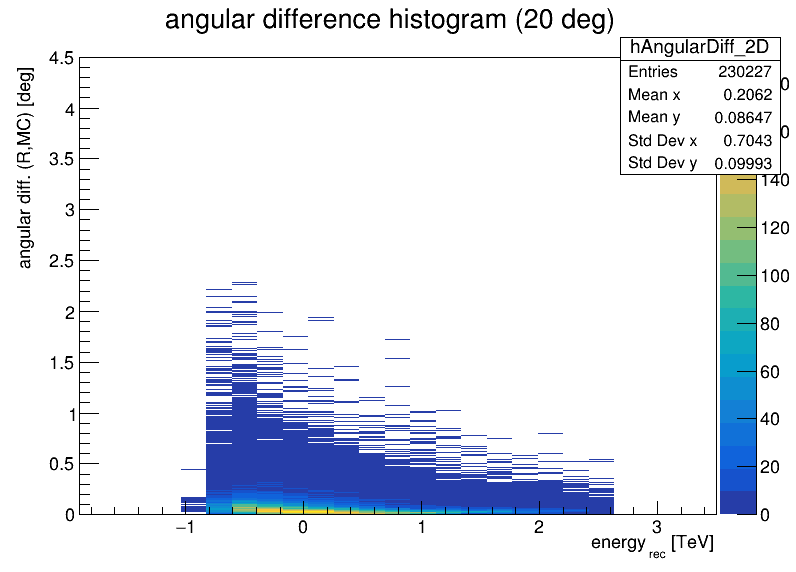

In [42]:
c = TCanvas("hAngularDiff_2D","hAngularDiff_2D",800,600)
hAngularDiff_2D.Draw("COLZ")
# c.SetLogy()
c.Draw()

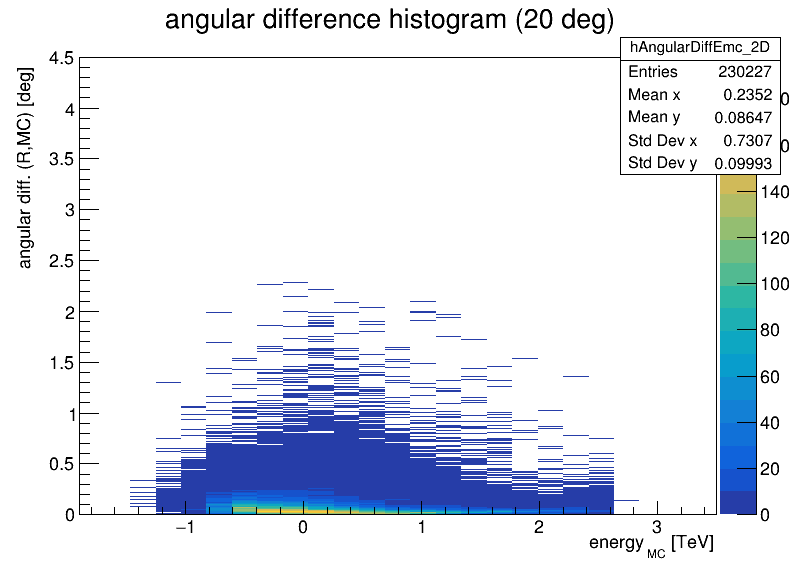

In [43]:
c = TCanvas("hAngularDiffEmc_2D","hAngularDiffEmc_2D",800,600)
hAngularDiffEmc_2D.Draw("COLZ")
# c.SetLogy()
c.Draw()

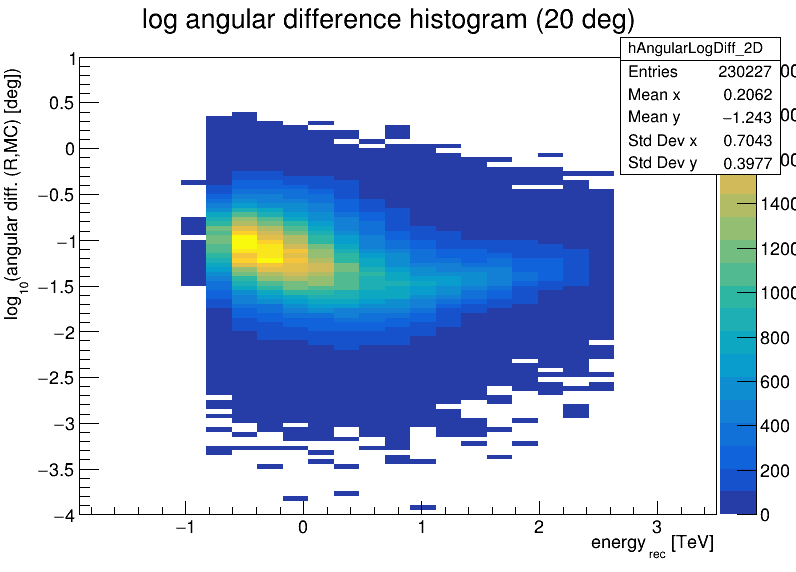

In [44]:
c = TCanvas("hAngularLogDiff_2D","hAngularLogDiff_2D",800,600)
hAngularLogDiff_2D.Draw("COLZ")
# c.SetLogy()
c.Draw()

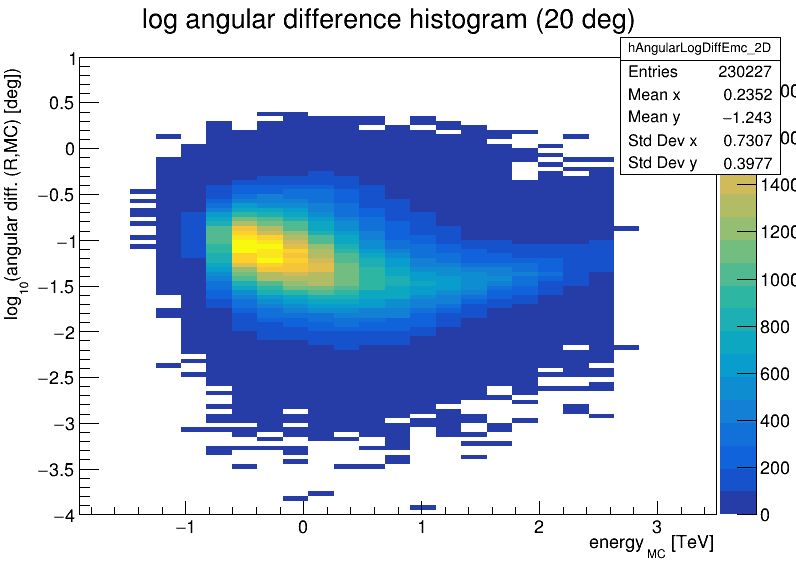

In [45]:
c = TCanvas("hAngularLogDiffEmc_2D","hAngularLogDiffEmc_2D",800,600)
hAngularLogDiffEmc_2D.Draw("COLZ")
# c.SetLogy()
c.Draw()

In [81]:
def bin_edges_to_centers(axis):
    # This function assumes bins of equal width
    bin_size = axis[1]-axis[0]
    return np.delete(axis + bin_size/2., len(axis)-1)

In [ ]:
migra, en = hist2array(hEsysMCRelative2D, return_edges=True)
true_energy = en[0]


In [ ]:
print(true_energy)
print(bin_edges_to_centers(true_energy))

In [ ]:
print(np.shape(migra))
print(np.shape(en[0]))
print(np.shape(en[1]))

In [ ]:
c = TCanvas("hEsysMCRelative2D","hEsysMCRelative2D",800,600)
hEsysMCRelative2D.Draw("COLZ")
# c.SetLogy()
c.Draw()

In [ ]:
en

In [ ]:
c = TCanvas("gEffAreaNoTh2MCList","gEffAreaNoTh2MCList",800,600)
for i, graph in enumerate(gEffAreaNoTh2MCList):
    if i == 0:
        graph.Draw("PAL")
    else:
        graph.Draw("SAME")
c.SetLogy()
c.Draw()

In [ ]:
print(effAreaList[1], effAreaList[2])

In [ ]:
np.meshgrid(10, 10, 10)

In [ ]:
c = TCanvas("gEffAreaNoTh2Rec","gEffAreaNoTh2Rec",800,600)
gEffAreaNoTh2MC.Draw("PAL")
c.SetLogy()
c.Draw()
print(graph_to_array(gEffAreaNoTh2MC))

In [ ]:
c = TCanvas("hEsysMCRelative2D","hEsysMCRelative2D",800,600)
hEsysMCRelative2D.Draw("COLZ")
c.Draw()

In [ ]:
hEsysMCRelative2D

In [ ]:
np.meshgrid(10, 10, 10)

In [ ]:
his = hist2array(hEsysMCRelative2D)

In [ ]:
his

In [ ]:
np.shape(his)

In [ ]:
np.array(hEsysMCRelative2D.GetArray())

In [ ]:
# hEsysMCRelative2D.GetNbinsX()
axis = hEsysMCRelative2D.GetXaxis()

In [ ]:
xarray = axis.GetXbins()

In [ ]:
x = [i for i in xarray.GetArray()]

In [ ]:
x

In [55]:
def graph_to_array(graph):
    y = [i for i in gEffAreaNoTh2MC.GetY()]
    return y

def th2_to_array(hist):
    return hist2array(hist)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def extract_irf(filename, irf_name, coord_tuple):
    # Get the coordinates to sample:
    azs = coord_tuple[0]
    indexs = coord_tuple[1]
    pedvars = coord_tuple[2]
    zds = coord_tuple[3]
    woffs = coord_tuple[4]
    
    # Get both the ROOT effective area TTree and the uproot one (much faster)
    effAreaFile = TFile.Open(filename)
    effAreaTree = effAreaFile.Get("fEffArea")
    fast_effArea = uproot.open(effAreaFileName)['fEffArea']
    
    all_zds = fast_effArea.array('ze')
    all_azs = fast_effArea.array('az')
    all_azMins = fast_effArea.array('azMin')
    all_azMaxs = fast_effArea.array('azMax')
    all_Woffs = fast_effArea.array('Woff')
    all_noises = fast_effArea.array('noise')
    # There are some bins with +0.01... Check those:
    all_pedvars = fast_effArea.array('pedvar')
    all_indexs = fast_effArea.array('index')
    
    for i, entry in enumerate(effAreaTree):
        if i == 0:
            if irf_name == 'eff':
                first_irf = [i for i in entry.eff]
                first_e0 = [i for i in entry.e0]
#             if irf_name == 'Rec_eff':
#                 irf = [i for i in entry.Rec_eff]
#             if irf_name == 'gEffAreaNoTh2MC':
#                 irf = entry.gEffAreaNoTh2MC
#             if irf_name == 'gEffAreaNoTh2Rec':
#                 irf = 
#             if irf_name == 'hEsysMCRelative2D':
#                 irf = 
#             if irf_name == 'hEsysMCRelative2DNoDirectionCut':
#                 irf = 
#             if irf_name == 'hAngularDiff_2D':
#                 irf = 
            else:
                raise Exception("WrongIrfName")
        else:
            break
    # Create np.array filled with zeros, containing the required dimensions
    data = np.zeros((len(first_irf), len(azs), len(indexs), len(pedvars), len(zds), len(woffs)))

    for i, entry in enumerate(effAreaTree):
        if i%500 == 0:
            print("{}/{}".format(i, len(all_zds)))
        if (np.isclose(azs, all_azs[i], atol=0.01).any() and
                np.isclose(indexs, all_indexs[i], atol=0.01).any() and
                np.isclose(pedvars, all_pedvars[i], atol=0.21).any() and
                np.isclose(zds, all_zds[i], atol=2.1).any() and
                np.isclose(woffs, all_Woffs[i], atol=0.05).any()):
#         if (all_azs[i] in azs and all_indexs[i] in indexs and all_pedvars[i] in pedvars and 
#                 all_zds[i] in zds and all_Woffs[i] in woffs):
            if irf_name == 'eff':
                e0 = [j for j in entry.e0]
                irf = [j for j in entry.eff]
#             if irf_name == 'Rec_eff':
#                 irf = [i for i in entry.Rec_eff]
#             if irf_name == 'gEffAreaNoTh2MC':
#                 irf = entry.gEffAreaNoTh2MC
#             if irf_name == 'gEffAreaNoTh2Rec':
#                 irf = 
#             if irf_name == 'hEsysMCRelative2D':
#                 irf = 
#             if irf_name == 'hEsysMCRelative2DNoDirectionCut':
#                 irf = 
#             if irf_name == 'hAngularDiff_2D':
#                 irf =  
            if len(irf) < len(first_irf):
                for j in np.arange(len(first_irf) - len(irf)):
                    irf.insert(0,0.)
            try:
                data[:, find_nearest(azs, all_azs[i]), find_nearest(indexs, all_indexs[i]), find_nearest(pedvars, all_pedvars[i]), 
                     find_nearest(zds, all_zds[i]), find_nearest(woffs, all_Woffs[i])] = irf
            except:
                print("Unexpected error:", sys.exc_info()[0])
                print("Entry number ", i)
                print(e0)
                raise
                
    return data

In [56]:
all_zds = fast_effArea.arrays('ze')
all_azs = fast_effArea.array('az')
all_azMins = fast_effArea.array('azMin')
all_azMaxs = fast_effArea.array('azMax')
all_Woffs = fast_effArea.array('Woff')
all_noises = fast_effArea.array('noise')
# There are some bins with +0.01... Check those:
all_pedvars = fast_effArea.array('pedvar')
all_indexs = fast_effArea.array('index')

NameError: name 'fast_effArea' is not defined

In [57]:
zes = np.unique(np.round(fast_effArea.array('ze'), decimals=1))
azs = np.unique(np.round(fast_effArea.array('az'), decimals=2))
azMins = np.unique(np.round(fast_effArea.array('azMin'), decimals=2))
azMaxs = np.unique(np.round(fast_effArea.array('azMax'), decimals=2))
Woffs = np.unique(np.round(fast_effArea.array('Woff'), decimals=2))
noises = np.unique(np.round(fast_effArea.array('noise'), decimals=2))
# There are some bins with +0.01... Check those:
pedvars = np.unique(np.round(fast_effArea.array('pedvar'), decimals=2))
# for i, pv in enumerate(pedvars):
#     if pv
indexs = np.unique(np.round(fast_effArea.array('index'), decimals=2))

NameError: name 'fast_effArea' is not defined

In [58]:
# We remove the duplicities from the zenith and pedestal values arrays:
zes = remove_duplicities(zes, 2.0)
pedvars = remove_duplicities(pedvars, 0.21)

NameError: name 'remove_duplicities' is not defined

In [ ]:
np.isclose(39., 40., atol=1.1)

In [ ]:
find_nearest(all_zds[b'ze'], 39.)

In [ ]:
len((0., 1.5, 4.4, zes))

In [ ]:
zes

In [ ]:
irf_data = extract_irf('/home/thassan/VERITAS/DL3/DL3_for_eventDisplay/EffectiveAreas_v501_rd/effArea-v501-TL5035MA20-auxv01-CARE_June1702-Cut-NTel2-PointSource-TMVA-BDT-Preselection-GEOID0-V6-ATM61-T1234.root',
                       'eff',
                       ([0], [1.5], [4.4], zes, [0.5]) )

In [ ]:
np.shape(irf_data)

In [ ]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)
for i in np.arange(np.shape(irf_data)[4]):
    ax.plot(np.arange(len(irf_data[:,0,0,0,i,0])), irf_data[:,0,0,0,i,0], marker='o', label='Zd = {} deg'.format(zes[i]))
ax.grid(color='gray', linestyle='-', linewidth=2)
ax.set_xlabel('# bin')
ax.set_yscale("log", nonposy='clip')
ax.set_ylabel('Effective area')
ax.legend()
fig.show()

In [ ]:
# First interpolator to test: (it allows un-even spacing)
from scipy.interpolate import RegularGridInterpolator
my_interpolating_function = RegularGridInterpolator((e0, [0], [1.5], [4.4], zes, [0.5]), irf_data)

# Evaluate the interpolating function at the two points (x,y,z) = (2.1, 6.2, 8.3) and (3.3, 5.2, 7.1):
# pts = np.array([[2.1, 6.2, 8.3], [3.3, 5.2, 7.1]])
# my_interpolating_function(pts)

In [ ]:
fig = plt.figure()
ax = fig.subplot(1,1,1)
ax.plot(np.arange(len(irf_data[:,0,0,0,0])), irf_data[:,0,0,0,0], marker='o')
ax.grid(color='gray', linestyle='-', linewidth=2)
ax.set_xlabel('# bin')
ax.set_yscale("log", nonposy='clip')
ax.set_ylabel('Effective area')
fig.show()

In [ ]:
if 4.4 in all_pedvars:
    print("works")

In [ ]:
if 0 in [0]:
    print("Works")

In [ ]:
all_zds

In [ ]:
irf_data[:,0,0,0,8,0]

In [ ]:
#     azs = coord_tuple[0]
#     indexs = coord_tuple[1]
#     pedvars = coord_tuple[2]
#     zds = coord_tuple[3]
#     woffs = coord_tuple[4]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.arange(len(irf_data[:,0,0,0,0])), irf_data[:,0,0,0,0], marker='o')
ax.grid(color='gray', linestyle='-', linewidth=2)
ax.set_xlabel('# bin')
ax.set_yscale("log", nonposy='clip')
ax.set_ylabel('Effective area')
fig.show()

In [ ]:
z = np.zeros((3,2,2))
z[:,0,0] = [1,2,3]

In [ ]:
z

In [ ]:
# First interpolator to test: (it allows un-even spacing)
from scipy.interpolate import RegularGridInterpolator

energy = e0
# Coordinates of the IRFs
x = np.linspace(1, 4, 11)
y = np.linspace(4, 7, 22)
z = np.linspace(7, 9, 33)
data = f(*np.meshgrid(x, y, z, indexing='ij', sparse=True))

# data is now a 3D array with data[i,j,k] = f(x[i], y[j], z[k]). Next, define an interpolating function from this data:

my_interpolating_function = RegularGridInterpolator((x, y, z), data)

# Evaluate the interpolating function at the two points (x,y,z) = (2.1, 6.2, 8.3) and (3.3, 5.2, 7.1):
pts = np.array([[2.1, 6.2, 8.3], [3.3, 5.2, 7.1]])
my_interpolating_function(pts)
# array([ 125.80469388,  146.30069388])

In [ ]:
np.isclose(zds, all_zds[i], atol=0.01).any()

In [ ]:
np.shape(data)